# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# 1. Data Exploration

In [1]:
# package imports
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import json
import datetime
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix, roc_auc_score
%matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## a) Portfolio data - offer information

First, let's take a quick look at the different offers in the portfolio:

In [3]:
portfolio.head(2)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0


In [4]:
print("There are {} unique offers in the portfolio.".format(portfolio['id'].nunique()))

offer_type_counts = portfolio.groupby('offer_type')['id'].count()
print("These are distributed among the offer types as follows:\n BOGO:\t\t{}\n Discount:\t{}\n Informational:\t{}".format(offer_type_counts.loc['bogo'], offer_type_counts.loc['discount'], offer_type_counts.loc['informational']))

There are 10 unique offers in the portfolio.
These are distributed among the offer types as follows:
 BOGO:		4
 Discount:	4
 Informational:	2


In [5]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

The different channels as well as the offer types need to be represented differently for analysis. Here is a function that can be used to clean the portfolio data set:

In [6]:
# Clean portfolio data set
def clean_portfolio(portfolio=portfolio):
    '''
    cleans the portfolio dataframe for further analysis
    
    INPUT:
    portfolio - the dataframe to be cleaned (default: portfolio)
    
    OUTPUT:
    portfolio - the cleaned portfolio dataframe
    
    '''
    # clean channels
    channels = pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).sum(level=0)
    portfolio = pd.concat([portfolio, channels], axis=1)
    
    # clean offer types
    offer_types = pd.get_dummies(portfolio.offer_type)
    portfolio = pd.concat([portfolio, offer_types], axis=1)
    
    portfolio['offer'] = (portfolio['offer_type'] + "_" + portfolio['reward'].astype('str')
                          + "_for_" + portfolio['difficulty'].astype('str') + "_in_"
                          + portfolio['duration'].astype('str') + "days")
    
    # drop and rename columns
    portfolio.drop(['channels'], axis=1, inplace=True)
    portfolio.rename(columns={'id':'offer_id'},inplace=True)
    
    return portfolio

In [7]:
portfolio = clean_portfolio()
portfolio

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web,bogo,discount,informational,offer
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0,bogo_10_for_10_in_7days
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0,bogo_10_for_10_in_5days
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1,informational_0_for_0_in_4days
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0,bogo_5_for_5_in_7days
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0,discount_5_for_20_in_10days
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0,discount_3_for_7_in_7days
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0,discount_2_for_10_in_10days
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1,informational_0_for_0_in_3days
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0,bogo_5_for_5_in_5days
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0,discount_2_for_10_in_7days


## Profile data - customer information

In [8]:
profile.head(2)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0


Again, here is a function to clean the profile data for further analysis:

In [9]:
def clean_profile(profile=profile):
    '''
    cleans the profile dataframe for further analysis
    
    INPUT:
    profile - the dataframe to be cleaned (default: profile)
    
    OUTPUT:
    profile - the cleaned profile dataframe
    
    ''' 
    # recode missing values for age
    profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)
    
    # drop entries with missing profile information
    #profile.dropna(inplace=True)
    
    # calculate membership duration
    profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
    profile['membership_duration'] = datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date
    profile['membership_duration'] = profile['membership_duration'].dt.days
    
    # rename columns
    profile.rename(columns={'id':'person_id'},inplace=True)
    
    return profile

In [10]:
profile = clean_profile()
profile

,gender,age,person_id,became_member_on,income,membership_duration
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,1500
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1347
2,None,NaN,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,985
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1414
4,None,NaN,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,1327
...,...,...,...,...,...,...
16995,F,45.0,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,1023
16996,M,61.0,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,984
16997,M,49.0,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,1517
16998,F,83.0,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,1842


In [11]:
profile.isnull().sum()

gender                 2175
age                    2175
person_id                 0
became_member_on          0
income                 2175
membership_duration       0
dtype: int64

Before proceeding to the actual event data, let's take a first look at the demographic information we have for our customers:

In [12]:
profile.describe()

,age,income,membership_duration
count,14825.000000,14825.000000,17000.000000
mean,54.393524,65404.991568,1488.449882
std,17.383705,21598.299410,411.223904
min,18.000000,30000.000000,971.000000
25%,42.000000,49000.000000,1179.000000
50%,55.000000,64000.000000,1329.000000
75%,66.000000,80000.000000,1762.000000
max,101.000000,120000.000000,2794.000000


In [13]:
def plot_demographics(df, variable):
    '''
    returns a basic histogram and density plot for demographic variables
    
    INPUT:
    df - the dataframe including the variable to be plotted
    variable - the variable to be plotted
    
    OUTPUT:
    plot - basic histogram and density plot
    
    ''' 
    plot = sns.displot(data=df, x=variable, kde=True, bins=25, aspect=1.5)
    plot.set(title='{} distribution'.format(variable))
    
    return plot

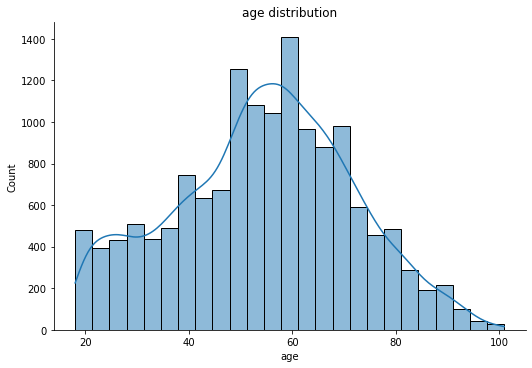

In [14]:
age_plot = plot_demographics(profile, 'age')

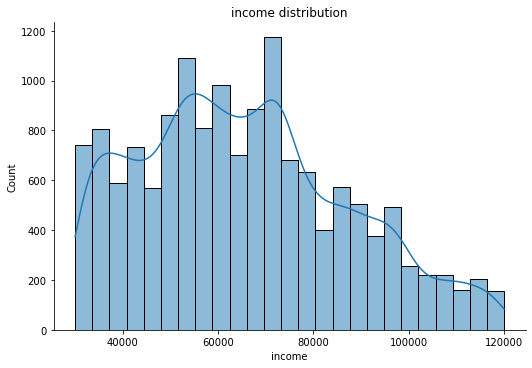

In [15]:
income_plot = plot_demographics(profile, 'income')

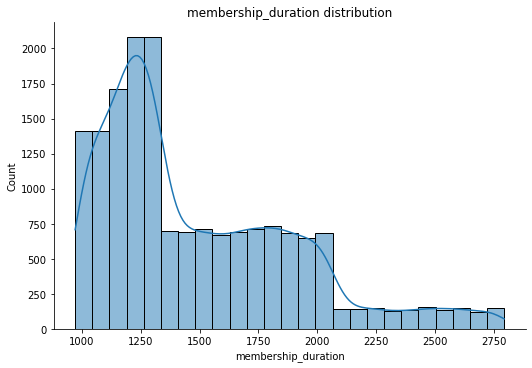

In [16]:
membership_duration_plot = plot_demographics(profile, 'membership_duration')

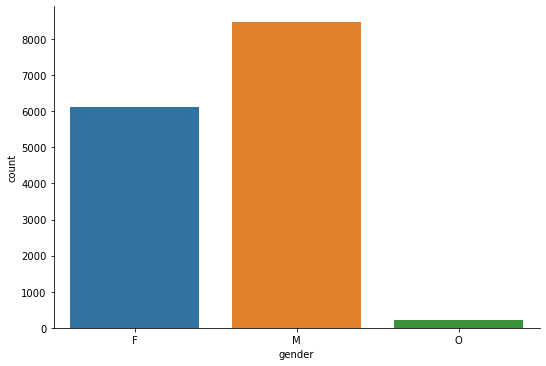

In [17]:
gender_plot = sns.catplot(data=profile, x='gender', kind='count', aspect=1.5)

## Transcript data - events

In [18]:
transcript.head(2)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [19]:
def clean_transcript(transcript=transcript):
    '''
    cleans the transcript dataframe for further analysis
    
    INPUT:
    transcript - the dataframe to be cleaned (default: transcript)
    
    OUTPUT:
    transcript - the cleaned transcript dataframe
    
    ''' 
    # unpack information in 'value' column to separate columns
    values = transcript['value'].apply(pd.Series)
    values.offer_id.fillna(values['offer id'], inplace=True)
    transcript = pd.concat([transcript, values], axis=1)
    
    # calculate number of offers received per person
    num_offers = transcript[transcript['event']=='offer received'].groupby('person').count().reset_index()
    num_offers.rename(columns={'offer_id':'num_offers'},inplace=True)
    transcript = pd.merge(transcript, num_offers[['person', 'num_offers']], how='left', on='person')
    
    # drop and rename columns
    transcript.drop(['offer id', 'value', 'reward'], axis=1, inplace=True)
    transcript.rename(columns={'person':'person_id'},inplace=True)
    
    return transcript

In [20]:
transcript = clean_transcript()
transcript

,person_id,event,time,amount,offer_id,num_offers
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,4.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,4.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,5.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,5.0
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59,NaN,3.0
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53,NaN,5.0
306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61,NaN,5.0
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53,NaN,3.0


In [21]:
transcript.isnull().sum()

person_id          0
event              0
time               0
amount        167581
offer_id      138953
num_offers        20
dtype: int64

To better understand how the event data look like and which factors need to be addressed during the analysis, let's first take a look at one customer:

In [22]:
transcript[transcript['person_id']=='78afa995795e4d85b5d9ceeca43f5fef']

,person_id,event,time,amount,offer_id,num_offers
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,4.0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,4.0
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,19.89,NaN,4.0
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,4.0
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,17.78,NaN,4.0
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,NaN,5a8bc65990b245e5a138643cd4eb9837,4.0
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,216,NaN,5a8bc65990b245e5a138643cd4eb9837,4.0
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,222,19.67,NaN,4.0
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,240,29.72,NaN,4.0
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,378,23.93,NaN,4.0


Looking at this subset of the transcript data for one customer, the following details become clear:

* A customer receives different offers over the course of the experiment; some overlap
* It can happen that an offer is completed without a customer having viewed the offer (see rows 218395 and 262138: the customer has already completed the offer before viewing it)

In [23]:
combined = pd.merge(transcript, portfolio, how='left', on='offer_id')
combined.groupby(['offer_type', 'event']).person_id.count()

offer_type     event          
bogo           offer completed    15669
               offer received     30499
               offer viewed       25449
discount       offer completed    17910
               offer received     30543
               offer viewed       21445
informational  offer received     15235
               offer viewed       10831
Name: person_id, dtype: int64

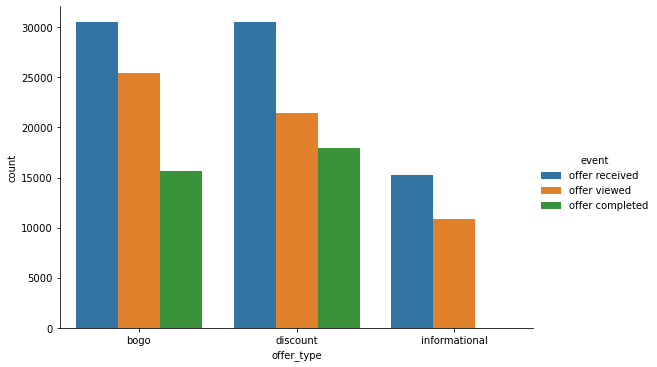

In [24]:
events_by_offer_type = sns.catplot(data=combined[combined['event']!='transaction'], x='offer_type',
                                   kind='count', hue='event', aspect=1.5)

As can be seen in the graph, there are roughly 30,000 BOGO and discount offers sent. Not all of them are viewed by customers, and again a smaller subset of those is completed.

What also becomes evident from the graph is that the informational offers need to be treated differently from the BOGO and dicsount offers, as there is no immediate measure for offer completion present in the data.

# 2. Data Analysis

Having done some basic data exploration and cleaning to get a better understanding of the data, my next goal is to investigate which customer groups respond particularly well to which offers so that future offers can be targeted at those groups. To do this, it is necessary to define which outcomes in the data can support these investigations.

## (a) BOGO and Discount Offers

In general, possible event paths for BOGO and discount offers are:
1. offer received --> offer viewed --> transaction(s) --> offer completed ('successful offer')
2. offer received --> offer viewed ('ineffective offer')
3. offer received --> transaction(s) --> offer completed ('unviewed success')
4. offer received ('unviewed offer')

While 1 is the path that reflects that an offer was successful, 2 (and 4) reflect that the offer was not successful, i.e., did not lead to transactions by the customer (or to insufficient transactions). It is important to keep in mind that 3 means that the customer has not viewed the offer, but completed it anyways, i.e., that the customer made transactions regardless of the offer.

Thus, it would be interesting to see how different customer groups show these behaviors in response to the offers: ideally, Starbucks might want to target those customer groups that exhibit event path 1, while not targeting those that are most likely to follow paths 2 and 4 (because those are not going to make transactions) or 3 (because those make transactions anyways, so Starbucks would actually lose money by giving them discounts or BOGO offers).

### Data preparation

To prepare the event data for analysis based on the thoughts above, I create separate data sets for the different types of offers:

In [25]:
bogo = combined[combined['offer_type']=='bogo']
discount = combined[combined['offer_type']=='discount']

Now, I have to transform the data sets to include my outcome variables:

In [39]:
def prepare_offer_data(df):
    pd.options.mode.chained_assignment = None
    
    # identify success cases in 'offer completed' rows
    offers_completed = df[['person_id', 'event', 'time', 'offer_id', 'num_offers']].sort_values(['person_id','time'])
    offers_completed = offers_completed[(offers_completed['event']=='offer viewed') | (offers_completed['event']=='offer completed')]
    offers_completed['pre_offer_id'] = offers_completed.groupby(['person_id', 'offer_id'])['offer_id'].shift()
    offers_completed['success'] = np.where((offers_completed['event'] == 'offer completed') & (offers_completed['pre_offer_id'] == offers_completed['offer_id']), 1, 0)
    offers_completed['unviewed_success'] = np.where((offers_completed['event'] == 'offer completed') & (offers_completed['pre_offer_id'].isna()), 1, 0)
    offers_completed.drop(['pre_offer_id'], axis=1, inplace=True)
    
    # re-include 'offer received' rows
    received_offers = df[['person_id', 'event', 'time', 'offer_id', 'num_offers']][df['event']=='offer received'].sort_values(['person_id','time'])
    
    together = received_offers.append(offers_completed).sort_values(['person_id','time'])
    together = together.sort_values(['person_id','time'])
    
    # transmit information from 'offer completed' to corresponding 'offer received' rows
    successes = together[(together['event']=='offer received') | (together['event']=='offer completed')]
    successes['success'] = successes.groupby(['person_id', 'offer_id'])['success'].bfill()
    successes['unviewed_success'] = successes.groupby(['person_id', 'offer_id'])['unviewed_success'].bfill()
    result = successes[successes['event']=='offer received']
    
    # classify remaining offers as failures and fill missings
    result['failure'] = np.where((result['success'].isna()) & (result['unviewed_success'].isna()), 1, 0)
    result['success'] = np.where(result['success'].isna(), 0, result['success'])
    result['success'] = result['success'].astype('int')
    result['unviewed_success'] = np.where(result['unviewed_success'].isna(), 0, result['unviewed_success'])
    result['unviewed_success'] = result['unviewed_success'].astype('int')
    
    # build categorical outcome column
    result['outcome'] = np.where(result['success'] == 1, 'success', np.where(result['unviewed_success'] == 1, 'unviewed success', 'failure'))

    outcome_map = {'failure': 0, 'unviewed success': 1, 'success': 2}
    result['outcome_factor'] = result['outcome'].map(outcome_map)
    
    # add customer and offer information
    combined = pd.merge(result, portfolio, how='left', on='offer_id')
    combined = pd.merge(combined, profile, how='left', on='person_id')
    combined.drop(['event', 'discount', 'informational', 'became_member_on'], axis=1, inplace=True)
    
    pd.options.mode.chained_assignment = "warn"
    
    return combined
    

In [40]:
bogo_cleaned = prepare_offer_data(bogo)
discount_cleaned = prepare_offer_data(discount)

In [41]:
bogo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71617 entries, 0 to 306444
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   person_id      71617 non-null  object 
 1   event          71617 non-null  object 
 2   time           71617 non-null  int64  
 3   amount         0 non-null      float64
 4   offer_id       71617 non-null  object 
 5   num_offers     71617 non-null  float64
 6   reward         71617 non-null  float64
 7   difficulty     71617 non-null  float64
 8   duration       71617 non-null  float64
 9   offer_type     71617 non-null  object 
 10  email          71617 non-null  float64
 11  mobile         71617 non-null  float64
 12  social         71617 non-null  float64
 13  web            71617 non-null  float64
 14  bogo           71617 non-null  float64
 15  discount       71617 non-null  float64
 16  informational  71617 non-null  float64
 17  offer          71617 non-null  object 
dtypes: fl

In [42]:
bogo_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30499 entries, 0 to 30498
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   person_id            30499 non-null  object 
 1   time                 30499 non-null  int64  
 2   offer_id             30499 non-null  object 
 3   num_offers           30499 non-null  float64
 4   success              30499 non-null  int64  
 5   unviewed_success     30499 non-null  int64  
 6   failure              30499 non-null  int64  
 7   outcome              30499 non-null  object 
 8   outcome_factor       30499 non-null  int64  
 9   reward               30499 non-null  int64  
 10  difficulty           30499 non-null  int64  
 11  duration             30499 non-null  int64  
 12  offer_type           30499 non-null  object 
 13  email                30499 non-null  uint8  
 14  mobile               30499 non-null  uint8  
 15  social               30499 non-null 

In [28]:
bogo_cleaned.head(10)

,person_id,time,offer_id,success,unviewed_success,failure,outcome,outcome_factor,reward,difficulty,...,email,mobile,social,web,bogo,offer,gender,age,income,membership_duration
0,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0,unviewed success,1,5,5,...,1,1,1,1,1,bogo_5_for_5_in_5days,M,33.0,72000.0,1432
1,00116118485d4dfda04fdbaba9a87b5c,168,f19421c1d4aa40978ebb69ca19b0e20d,0,0,1,failure,0,5,5,...,1,1,1,1,1,bogo_5_for_5_in_5days,None,NaN,NaN,1063
2,00116118485d4dfda04fdbaba9a87b5c,576,f19421c1d4aa40978ebb69ca19b0e20d,0,0,1,failure,0,5,5,...,1,1,1,1,1,bogo_5_for_5_in_5days,None,NaN,NaN,1063
3,0011e0d4e6b944f998e987f904e8c1e5,504,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,success,2,5,5,...,1,1,0,1,1,bogo_5_for_5_in_7days,O,40.0,57000.0,1169
4,0020c2b971eb4e9188eac86d93036a77,168,ae264e3637204a6fb9bb56bc8210ddfd,0,0,1,failure,0,10,10,...,1,1,1,0,1,bogo_10_for_10_in_7days,F,59.0,90000.0,1845
5,0020c2b971eb4e9188eac86d93036a77,408,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,success,2,10,10,...,1,1,1,1,1,bogo_10_for_10_in_5days,F,59.0,90000.0,1845
6,0020ccbbb6d84e358d3414a3ff76cffd,336,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,success,2,5,5,...,1,1,1,1,1,bogo_5_for_5_in_5days,F,24.0,60000.0,1593
7,0020ccbbb6d84e358d3414a3ff76cffd,504,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,success,2,5,5,...,1,1,0,1,1,bogo_5_for_5_in_7days,F,24.0,60000.0,1593
8,004b041fbfe44859945daa2c7f79ee64,504,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,success,2,5,5,...,1,1,1,1,1,bogo_5_for_5_in_5days,F,55.0,74000.0,1050
9,004c5799adbf42868b9cff0396190900,336,ae264e3637204a6fb9bb56bc8210ddfd,0,1,0,unviewed success,1,10,10,...,1,1,1,0,1,bogo_10_for_10_in_7days,M,54.0,99000.0,1818


In [29]:
discount_cleaned.head(10)

,person_id,time,offer_id,success,unviewed_success,failure,outcome,outcome_factor,reward,difficulty,...,email,mobile,social,web,bogo,offer,gender,age,income,membership_duration
0,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,unviewed success,1,2,10,...,1,1,1,1,0,discount_2_for_10_in_10days,M,33.0,72000.0,1432
1,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,0,1,0,unviewed success,1,2,10,...,1,1,0,1,0,discount_2_for_10_in_7days,M,33.0,72000.0,1432
2,0011e0d4e6b944f998e987f904e8c1e5,168,2298d6c36e964ae4a3e7e9706d1fb8c2,1,0,0,success,2,3,7,...,1,1,1,1,0,discount_3_for_7_in_7days,O,40.0,57000.0,1169
3,0011e0d4e6b944f998e987f904e8c1e5,408,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,success,2,5,20,...,1,0,0,1,0,discount_5_for_20_in_10days,O,40.0,57000.0,1169
4,0020c2b971eb4e9188eac86d93036a77,0,fafdcd668e3743c1bb461111dcafc2a4,1,0,0,success,2,2,10,...,1,1,1,1,0,discount_2_for_10_in_10days,F,59.0,90000.0,1845
5,0020c2b971eb4e9188eac86d93036a77,336,fafdcd668e3743c1bb461111dcafc2a4,1,0,0,success,2,2,10,...,1,1,1,1,0,discount_2_for_10_in_10days,F,59.0,90000.0,1845
6,0020ccbbb6d84e358d3414a3ff76cffd,168,2298d6c36e964ae4a3e7e9706d1fb8c2,1,0,0,success,2,3,7,...,1,1,1,1,0,discount_3_for_7_in_7days,F,24.0,60000.0,1593
7,003d66b6608740288d6cc97a6903f4f0,168,fafdcd668e3743c1bb461111dcafc2a4,1,0,0,success,2,2,10,...,1,1,1,1,0,discount_2_for_10_in_10days,F,26.0,73000.0,1371
8,003d66b6608740288d6cc97a6903f4f0,408,fafdcd668e3743c1bb461111dcafc2a4,1,0,0,success,2,2,10,...,1,1,1,1,0,discount_2_for_10_in_10days,F,26.0,73000.0,1371
9,003d66b6608740288d6cc97a6903f4f0,504,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,unviewed success,1,5,20,...,1,0,0,1,0,discount_5_for_20_in_10days,F,26.0,73000.0,1371


### Model Estimation

Now that the data sets are prepared, my goal is to build a model that predicts offer outcome based on the demographic and offer information available in the data. Ideally, this model can be used to further refine offers and target them at new customers in the future.

To this end, I build a simple classification model using a Random Forest Classification algorithm. The model function below also reports basic evaluation metrics for the model built:

In [30]:
def build_classification_model(df, target, target_names):
    
    df = df.dropna(how='any', axis=0)
    
    gender = pd.get_dummies(df.gender)
    df = pd.concat([df, gender], axis=1)
    
    X = df.drop(columns=['person_id', 'offer_id', 'time', 'offer_type', 'gender', 'offer',
                         'success', 'unviewed_success', 'failure', 'outcome', 'outcome_factor'])
    y = df.pop(target)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42)
    
    model = RandomForestClassifier(max_depth=20, oob_score=True, n_estimators=504,
                                   max_features='log2', random_state=42)
    #model = RandomForestClassifier(min_samples_leaf=50, n_estimators=150, bootstrap=True,
    #                               oob_score=True, n_jobs=-1, random_state=42, max_features='auto')
    model.fit(X_train, y_train)
    
    conf_matrix = plot_confusion_matrix(model, X_test, y_test, display_labels=target_names, cmap=plt.cm.Blues, normalize=None)
    conf_matrix.ax_.set_title('Confusion matrix')
    
    model_predictions = model.predict(X_test)
    print(classification_report(y_test, model_predictions, target_names=target_names))
    
    print("Overall model accuracy:\t {}".format(accuracy_score(y_test, model_predictions)))
    
    train_probs = model.predict_proba(X_train)
    model_probs = model.predict_proba(X_test)
    print("Train ROC AUC score:\t {}".format(roc_auc_score(y_train, train_probs, multi_class='ovo')))
    print("Test ROC AUC score:\t {}".format(roc_auc_score(y_test, model_probs, multi_class='ovo')))
    
    feat_imp = pd.DataFrame(model.feature_importances_, index=X_train.columns,
                            columns=['importance']).sort_values('importance', ascending=False)
    
    plot = sns.catplot(data=feat_imp.reset_index(), y='index', x='importance', kind='bar', aspect=2)
    plot.set(title='Feature importance')
    
    return model

### BOGO model

                  precision    recall  f1-score   support

         failure       0.66      0.67      0.66      4329
unviewed success       0.33      0.16      0.21      1514
         success       0.62      0.72      0.66      4772

        accuracy                           0.62     10615
       macro avg       0.54      0.51      0.51     10615
    weighted avg       0.59      0.62      0.60     10615

Overall model accuracy:	 0.6153556288271315
Train ROC AUC score:	 0.9991374754241636
Test ROC AUC score:	 0.728885196190625


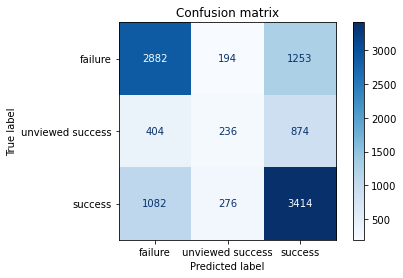

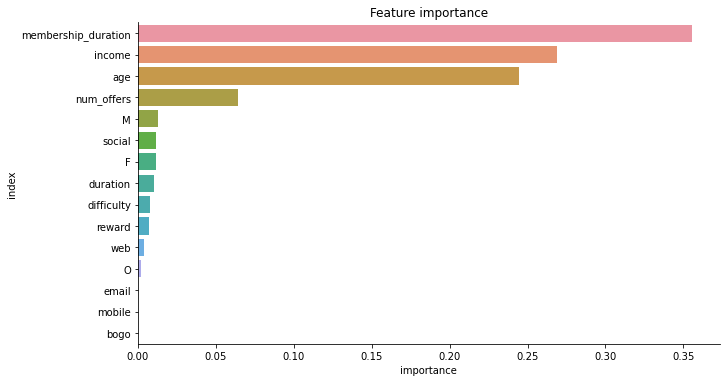

In [43]:
bogo_model = build_classification_model(bogo_cleaned, 'outcome_factor',
                                        ['failure', 'unviewed success', 'success'])

### Discount model

                  precision    recall  f1-score   support

         failure       0.63      0.64      0.64      3617
unviewed success       0.42      0.25      0.31      1847
         success       0.68      0.77      0.73      5202

        accuracy                           0.64     10666
       macro avg       0.58      0.55      0.56     10666
    weighted avg       0.62      0.64      0.62     10666

Overall model accuracy:	 0.6378211138196137
Train ROC AUC score:	 0.9991558177629066
Test ROC AUC score:	 0.758329496400966


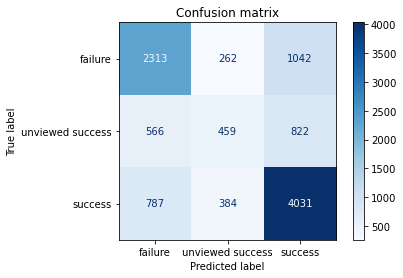

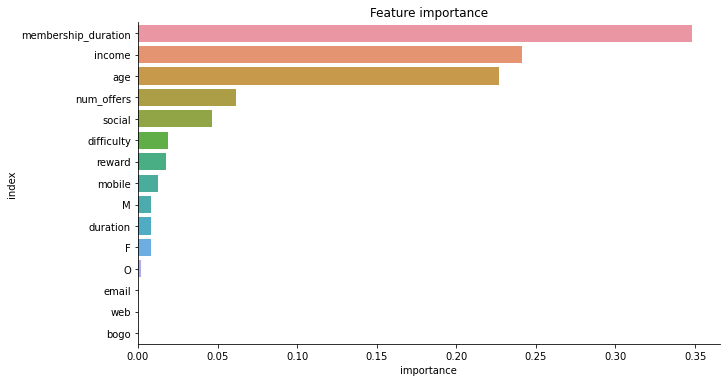

In [46]:
discount_model = build_classification_model(discount_cleaned, 'outcome_factor',
                                            ['failure', 'unviewed success', 'success'])

### Combined model

In [44]:
bogo_discount = bogo_cleaned.append(discount_cleaned)
bogo_discount

,person_id,time,offer_id,num_offers,success,unviewed_success,failure,outcome,outcome_factor,reward,...,email,mobile,social,web,bogo,offer,gender,age,income,membership_duration
0,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,5.0,0,1,0,unviewed success,1,5,...,1,1,1,1,1,bogo_5_for_5_in_5days,M,33.0,72000.0,1432
1,00116118485d4dfda04fdbaba9a87b5c,168,f19421c1d4aa40978ebb69ca19b0e20d,2.0,0,0,1,failure,0,5,...,1,1,1,1,1,bogo_5_for_5_in_5days,None,NaN,NaN,1063
2,00116118485d4dfda04fdbaba9a87b5c,576,f19421c1d4aa40978ebb69ca19b0e20d,2.0,0,0,1,failure,0,5,...,1,1,1,1,1,bogo_5_for_5_in_5days,None,NaN,NaN,1063
3,0011e0d4e6b944f998e987f904e8c1e5,504,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,1,0,0,success,2,5,...,1,1,0,1,1,bogo_5_for_5_in_7days,O,40.0,57000.0,1169
4,0020c2b971eb4e9188eac86d93036a77,168,ae264e3637204a6fb9bb56bc8210ddfd,5.0,0,0,1,failure,0,10,...,1,1,1,0,1,bogo_10_for_10_in_7days,F,59.0,90000.0,1845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30538,ffff82501cea40309d5fdd7edcca4a07,0,fafdcd668e3743c1bb461111dcafc2a4,6.0,1,0,0,success,2,2,...,1,1,1,1,0,discount_2_for_10_in_10days,F,45.0,62000.0,1579
30539,ffff82501cea40309d5fdd7edcca4a07,168,0b1e1539f2cc45b7b9fa7c272da2e1d7,6.0,1,0,0,success,2,5,...,1,0,0,1,0,discount_5_for_20_in_10days,F,45.0,62000.0,1579
30540,ffff82501cea40309d5fdd7edcca4a07,336,2906b810c7d4411798c6938adc9daaa5,6.0,1,0,0,success,2,2,...,1,1,0,1,0,discount_2_for_10_in_7days,F,45.0,62000.0,1579
30541,ffff82501cea40309d5fdd7edcca4a07,408,2906b810c7d4411798c6938adc9daaa5,6.0,1,0,0,success,2,2,...,1,1,0,1,0,discount_2_for_10_in_7days,F,45.0,62000.0,1579


                  precision    recall  f1-score   support

         failure       0.64      0.66      0.65      7846
unviewed success       0.39      0.22      0.28      3357
         success       0.66      0.74      0.70     10078

        accuracy                           0.63     21281
       macro avg       0.56      0.54      0.54     21281
    weighted avg       0.61      0.63      0.61     21281

Overall model accuracy:	 0.6281659696442836
Train ROC AUC score:	 0.998602492052763
Test ROC AUC score:	 0.7499471050702743


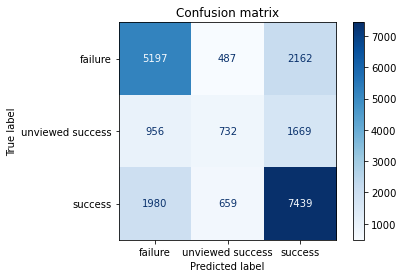

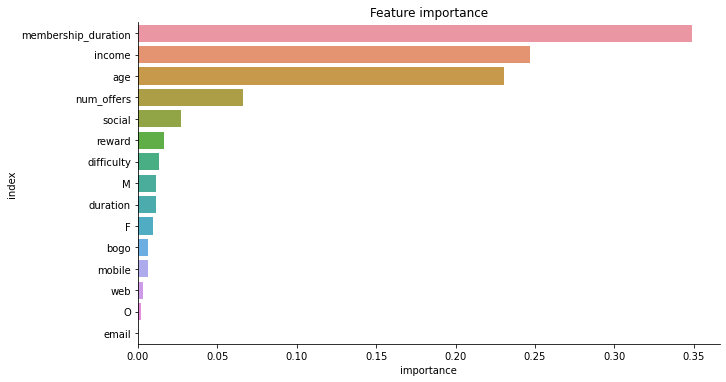

In [45]:
bogo_discount_model = build_classification_model(bogo_discount, 'outcome_factor',
                                                 ['failure', 'unviewed success', 'success'])

### Improving Model Performance

In [ ]:
# TODO: Use GridSearch to improve model performance

In [48]:
cv = RandomizedSearchCV(estimator = RandomForestClassifier(random_state=42),
                        param_distributions = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 700, num = 50)],
                                               'max_features': ['auto', 'log2'],
                                               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
                                               'min_samples_split': [2, 5, 10],
                                               'min_samples_leaf': [1, 4, 10],
                                               'bootstrap': [True, False]},
                        n_iter = 50, cv = 3, verbose = 1, random_state = 42,
                        scoring = 'roc_auc')

bogo_discount = bogo_discount.dropna(how='any', axis=0)    
gender = pd.get_dummies(bogo_discount.gender)
bogo_discount = pd.concat([bogo_discount, gender], axis=1)

X = bogo_discount.drop(columns=['person_id', 'offer_id', 'time', 'offer_type', 'gender', 'offer',
                                 'success', 'unviewed_success', 'failure', 'outcome', 'outcome_factor'])
y = bogo_discount.pop('outcome_factor')
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42)

cv.fit(X_train, y_train)

cv.best_params_

KeyError: "['person_id' 'offer_id' 'time' 'offer_type' 'gender' 'offer' 'success'\n 'unviewed_success' 'failure' 'outcome' 'outcome_factor'] not found in axis"

### Descriptive analysis of most important features

#### Membership duration

In [ ]:
outcome_by_duration = sns.displot(data=bogo_discount, x='membership_duration',
                                  kind='kde', hue='outcome', aspect=1.5)

In [ ]:
bogo_discount.groupby('outcome')['membership_duration'].mean()

#### Income

In [ ]:
outcome_by_income = sns.displot(data=bogo_discount, x='income', kind='kde', hue='outcome', aspect=1.5)

In [ ]:
bogo_discount.groupby('outcome')['income'].mean()

#### Age

In [ ]:
outcome_by_age = sns.displot(data=bogo_discount, x='age', kind='kde', hue='outcome', aspect=1.5)

In [ ]:
bogo_discount.groupby('outcome')['age'].mean()

#### Gender

In [ ]:
outcome_by_gender = sns.catplot(data=bogo_discount, x='gender', kind='count', hue='outcome', aspect=1.5)

### Which offers are most successful?

In [ ]:
bogo_discount.head()

In [ ]:
outcome_by_offer = sns.catplot(data=bogo_discount, x='offer', kind='count',
                               hue='outcome', aspect=1.5)
outcome_by_offer = outcome_by_offer.set_xticklabels(rotation=90)

## (b) Informational Offers

For informational offers, there is no 'offer completed' event. Thus, for evaluating offer success, I use transaction data.

### Data Preparation

In [ ]:
informational = combined[(combined['offer_type']=='informational') |(combined['event']=='transaction')]

In [ ]:
def prepare_info_data(df):
    
    test = df.sort_values(['person_id','time'])

    # calculate remaining time for offers
    test['duration_hrs'] = test.duration * 24
    test['end_time'] = np.where(test['event']=='offer received', test['time'] + test['duration_hrs'], np.nan)
    test['end_time'] = test.groupby('person_id')['end_time'].ffill()
    test['remaining'] = test['end_time'] - test.time

    # fill in offer column for transactions if offer is still active
    test['offer'] = np.where((test['event']=='transaction') & (test['remaining']>=0), test['offer'].ffill(), test.offer)

    # get rid of all transactions that do not belong to an offer
    test = test[-test['offer'].isna()]

    # calculate transaction sum during offer validity period using transactions and offer viewed
    test_rest = test[(test['event']=='offer viewed')|(test['event']=='transaction')]
    uff = pd.DataFrame(test_rest.groupby(['person_id', 'offer'])['amount'].sum())
    uff.rename(columns={'amount':'sum'},inplace=True)
    test_rest_sum = pd.merge(test_rest, uff, how='left', on=['person_id', 'offer'])
    test_rest_sum['amount'] = np.where(test_rest_sum['event']=='offer viewed', test_rest_sum['sum'], test_rest_sum['amount'])
    test = test[test['event']=='offer received'].append(test_rest_sum).sort_values(['person_id','time'])
    test = test.drop(columns=['duration_hrs', 'end_time', 'remaining', 'sum'])

    # transfer transaction sum to 'offer received' rows
    test = test[-(test['event']=='transaction')]
    test['amount'] = test.groupby(['person_id', 'offer'])['amount'].shift(-1)
    test = test[test['event']=='offer received']
    test['amount'] = test['amount'].fillna(0)
    
    # add customer information
    test = pd.merge(test, profile, how='left', on='person_id')
    test.drop(['event', 'discount', 'bogo', 'informational', 'offer_type', 'became_member_on'], axis=1, inplace=True)

    return test

In [ ]:
info_cleaned = prepare_info_data(informational)
info_cleaned

In [ ]:
# TODO: Model for Informational Offers

## 3. Discussion

In [ ]:
# TODO: Discussion

## Playground

### Estimate Multioutput Model

In [ ]:
def multioutput_model(df, target_names):
    
    df = df.dropna(how='any', axis=0)
    
    gender = pd.get_dummies(df.gender)
    df = pd.concat([df, gender], axis=1)
    
    X = df.drop(columns=['person_id', 'offer_id', 'time', 'offer_type',
                         'gender', 'success', 'unviewed_success', 'failure', 'outcome', 'outcome_factor'])
    Y = df[['success', 'unviewed_success', 'failure']]
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.4, random_state=42)
    
    model = MultiOutputClassifier(RandomForestClassifier(max_depth=20, random_state=42))
    model.fit(X_train, Y_train)
    
    model_predictions = model.predict(X_test)
    
    print(classification_report(Y_test, model_predictions, target_names=target_names))
    
    print("The overall model accuracy is {}.".format(model.score(X_test, Y_test)))
    
    return model

In [ ]:
from sklearn.multioutput import MultiOutputClassifier

bogo_multi = multioutput_model(bogo_discount.drop(columns=['offer']), ['success', 'unviewed_success', 'failure'])